<a href="https://colab.research.google.com/github/Poojitha20-B/Deep-Reinforcement-Learning-Internship/blob/main/Custom_CNN_Vs_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Custom CNN Vs ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [ ]:
# Normalize for Custom CNN
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm = x_test.astype("float32") / 255.0


In [ ]:
# One-hot encode
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [ ]:
custom_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_custom = custom_model.fit(
    x_train_norm, y_train_cat,
    epochs=15, batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3)]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.2759 - loss: 1.9435 - val_accuracy: 0.4991 - val_loss: 1.3900
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4946 - loss: 1.4017 - val_accuracy: 0.5878 - val_loss: 1.1768
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5641 - loss: 1.2301 - val_accuracy: 0.6248 - val_loss: 1.0570
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6036 - loss: 1.1262 - val_accuracy: 0.6494 - val_loss: 0.9905
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6438 - loss: 1.0182 - val_accuracy: 0.6777 - val_loss: 0.9123
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6673 - loss: 0.9512 - val_accuracy: 0.6692 - val_loss: 0.9420
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6934 - loss: 0.8821 - val_accuracy: 0.6696 - val_loss: 0.9374
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7112 - loss: 0.8286 - val_accuracy: 

In [ ]:
def preprocess_resnet(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    return image, label

# tf.data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat)).map(preprocess_resnet).batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat)).map(preprocess_resnet).batch(64).prefetch(tf.data.AUTOTUNE)


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True

# Freeze lower layers
for layer in base_model.layers[:100]:
    layer.trainable = False

transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train
history_transfer = transfer_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=[EarlyStopping(patience=3)]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 297s 326ms/step - accuracy: 0.7985 - loss: 0.6298 - val_accuracy: 0.9318 - val_loss: 0.2047
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 285s 304ms/step - accuracy: 0.9591 - loss: 0.1229 - val_accuracy: 0.9374 - val_loss: 0.2228
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 264s 307ms/step - accuracy: 0.9825 - loss: 0.0545 - val_accuracy: 0.9377 - val_loss: 0.2295
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 261s 306ms/step - accuracy: 0.9857 - loss: 0.0452 - val_accuracy: 0.9347 - val_loss: 0.2773


In [ ]:
# Evaluate both models
loss1, acc1 = custom_model.evaluate(x_test_norm, y_test_cat, verbose=0)
loss2, acc2 = transfer_model.evaluate(test_ds, verbose=0)

print(f"Custom CNN Accuracy: {acc1:.4f}")
print(f"ResNet50 Transfer Learning Accuracy: {acc2:.4f}")


Custom CNN Accuracy: 0.7209
ResNet50 Transfer Learning Accuracy: 0.9347


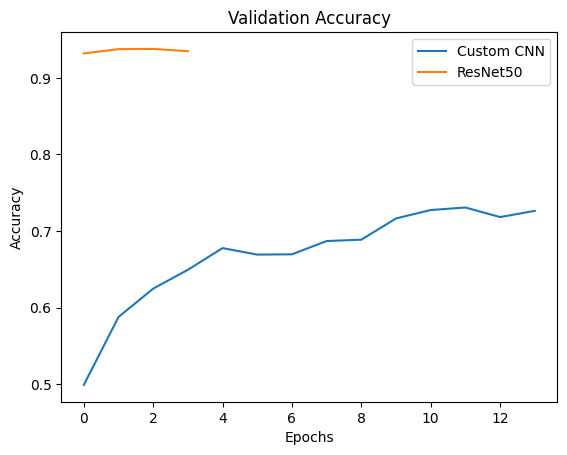

In [ ]:
plt.plot(history_custom.history['val_accuracy'], label='Custom CNN')
plt.plot(history_transfer.history['val_accuracy'], label='ResNet50')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Observations

| **Model**           | **Dataset** | **Test Accuracy** | **Remarks**                                                 |
| ------------------- | ----------- | ----------------- | ----------------------------------------------------------- |
| Custom CNN          | CIFAR-10    | 72.09%            | Lightweight model, learned basic features decently.         |
| ResNet50 (Transfer) | CIFAR-10    | 93.47%            | Pretrained, deeper model — handled complex patterns better. |


Custom CNN vs ResNet50 on CIFAR-10:
Custom CNN gave around 72.09% accuracy. It learned basic patterns well but kinda hit a limit since it was light and had fewer layers.

ResNet50 with transfer learning crushed it with 93.47% accuracy — pretrained on ImageNet, so it already knew how to handle visual features better.

Clearly shows how transfer learning + deeper model gives a massive boost. ResNet just needed a little fine-tuning and it outperformed custom CNN by a big margin.